# Step 8: Attempt to modify potentially problematic spectra through fit to data

Since biases are large, and some of the spectra may be problematic for pure endmembers, let us now permit modifications to those spectra. Vary F for some of the endmembers which are predicted with high abundances far away from their expected global average values. 

The loss function to be minimized should be the prediction error on a minibatch of RaCA spectra.

Can also try 1/R^2 - 1, where R^2 is the coefficient of regression for a plot of predicted vs. actual carbon content on a large minibatch of RaCA.

In [163]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

#plt.rcParams['text.usetex'] = True

### Load RaCA data and post-process spectra

In [2]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [3]:
#data[0,2152:]
#sample_top   = data[1:,2153].astype('float32')
#sample_bot   = data[1:,2154].astype('float32')
#sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [4]:
#dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [22]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

  0%|          | 0/121376 [00:00<?, ?it/s]

In [5]:
import pickle

with open('RaCA-data.pkl', 'rb') as file:
        dataI = pickle.load(file)

In [121]:
del data

### Define basic model parameters

In [60]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA,axis=1)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA,axis=1)).t()

### Define models: Encoder and Decoder, Mixing Model and AdamUnmixer

In [7]:
class LinearMixingEncoder(nn.Module):
    def __init__(self, M, K, hidden_size):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.BatchNorm1d(M),
            nn.Linear(M, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            
            # Collection of hidden layers
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            
            # Convert to vector of mass abundances.
            nn.Linear(hidden_size, K), 
            
            # No subsequent BatchNorm on last layer.
            
            # Use leaky ReLU: has gradient !=0 at large negative values
            # so that very small abundances (large neg. values at this layer)
            # sit in a region of nonvanishing gradient
            nn.LeakyReLU()            
        )
        
        # Softmax to ensure abundances add up to 1
        self.smax = nn.Softmax() 
        
    def forward(self, y):
        y_mlp = self.mlp(y);
        ms = self.smax(y_mlp);
        return ms

In [8]:
class LinearMixingDecoder(nn.Module):
    def __init__(self, seedFs, seedMs, rhorad):
        super().__init__()
        
        # fixed quantities
        self.rhorad = rhorad[:-1]
        
        # model parameters
        self.Fs     = nn.Parameter(seedFs)
        self.rrsoc  = nn.Parameter(rhorad[-1])
        
    def forward(self, Ms):
        rrFull = torch.cat((self.rhorad,self.rrsoc.unsqueeze(0)))
        Ihat   = torch.matmul(torchA(Ms,rrFull).float(),self.Fs.float())
        
        return Ihat
                
    def computeLagrangeLossFactor(self) :
        # Add in a fake Lagrange multiplier to discourage Fs < 0 and Fs > 1
        oobsF = 1.0 * torch.sum((self.Fs < 0.0).float() * (self.Fs ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.Fs > 1.0).float() * (1.0 - self.Fs) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.Fs) ** 2)
        diffloss += torch.sum(torch.diff(torch.diff(self.Fs)) ** 2)
        
        # Compute the loss function, which is chi-squared/NDF for spectra (1% SD) and msoc
        # with a multiplicative factor for our fake Lagrange multipliers
        return (1 + 100.0* diffloss + 1000.0*oobsF) 

In [9]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = nn.Parameter(seedrrsoc)
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.bdsFLoss = np.zeros(nepochs);
        self.omrsLoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0 and Fsoc > 1
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF) # + 10000.0*omrs
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.bdsFLoss[self.epoch] = oobsF.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss

In [10]:
class LinearMixingSOCPredictor(nn.Module):
    def __init__(self, seedFs, seedMs, trueMsoc, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad;
        self.fs     = seedFs;
        self.truemsoc = trueMsoc;
        
        # model parameters
        self.rrsoc  = nn.Parameter(seedrrsoc);
        self.ms     = nn.Parameter(seedMs);
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.socbias = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        rrFull    = torch.cat((self.rhorad,self.rrsoc.unsqueeze(0)))
        mFull     = (self.ms.t() / torch.sum(self.ms)).t()
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),self.fs.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.Ihat) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.Ihat)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((y - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA)
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.socbias[self.epoch]  = self.truemsoc - mFull[-1];
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss

### Load pre-trained abundances from fit to data

In [122]:
print("Pytorch CUDA Version is ", torch.version.cuda)
print("Whether CUDA is supported by our system:", torch.cuda.is_available())
cuda_id = torch.cuda.current_device()
print("Name of the current CUDA Device: ", torch.cuda.get_device_name(cuda_id))
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Pytorch CUDA Version is  11.7
Whether CUDA is supported by our system: True
Name of the current CUDA Device:  NVIDIA GeForce RTX 4090
cuda


In [12]:
import pickle
        
with open('step5_fullFit_E200k_lr0p00002_b1_0p99_b2_0p999.pkl', 'rb') as file:
        (model,_,_,_,_,_,dataIndices,msoc,_,_,_) = pickle.load(file)

In [118]:
ttrrFull = torch.cat((model.rhorad,model.rrsoc))
ttmFull  = torch.cat((model.ms,torch.tensor(msoc.tolist()).unsqueeze(1)),dim=1)
ttmFull  = (ttmFull.t() / torch.sum(ttmFull,axis=1)).t()
ttfFull  = torch.cat((model.fs,model.fsoc.unsqueeze(0)),dim=0)
ttIhat   = torch.matmul(torchA(ttmFull,ttrrFull).float(),ttfFull.float())

In [119]:
rrFullRaCAFit = ttrrFull.detach().numpy()
msFullRaCAFit = ttmFull.detach().numpy()
FsFullRaCAFit = ttfFull.detach().numpy()
IhFullRaCAFit = ttIhat.detach().numpy()
del ttrrFull, ttmFull, ttfFull, ttIhat, model

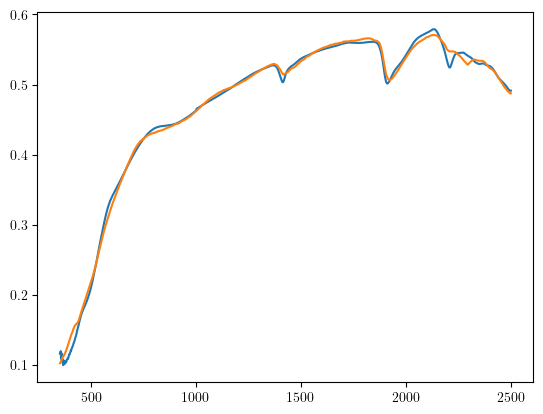

In [120]:
plt.plot(XF, dataI[dataIndices][0])
plt.plot(XF, IhFullRaCAFit[0])

### Train seed encoder model on abundances from fit to data

In [123]:
KEndmembers = 90
NPoints = IhFullRaCAFit.shape[0]
MSpectra = 2151

In [124]:
# Truth-level outputs: regressed abundances from an LMM
tMs  = torch.tensor(msFullRaCAFit.tolist()).to(device)

# Truth-level inputs: Individual spectra
tIs = torch.tensor(IhFullRaCAFit.tolist()).to(device)

# Training settings, optimizer declarations
nepochs = 20000
seedEncoderModel = LinearMixingEncoder(MSpectra, KEndmembers, 512).to(device)
optimizer = optim.Adam(seedEncoderModel.parameters(), lr = 0.000005, betas=(0.99,0.999))
preds = []

In [125]:
model_parameters = filter(lambda p: p.requires_grad, seedEncoderModel.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1944360


In [126]:
# Optimizer tracking
cEpoch = 0
lossTracking = np.zeros(nepochs);

In [127]:
for epoch in tqdm(range(nepochs)) :
    preds = seedEncoderModel(tIs)
    loss = (preds - tMs)**2
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossTracking[cEpoch] = e.detach().item()
    cEpoch += 1

print("Epoch ",epoch,": ", lossTracking[-1], lossTracking[-1] / (0.01 ** 2) / (KEndmembers))

  0%|          | 0/20000 [00:00<?, ?it/s]

/tmp/ipykernel_12860/2082774099.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms = self.smax(y_mlp);


KeyboardInterrupt: 

#### Check training output

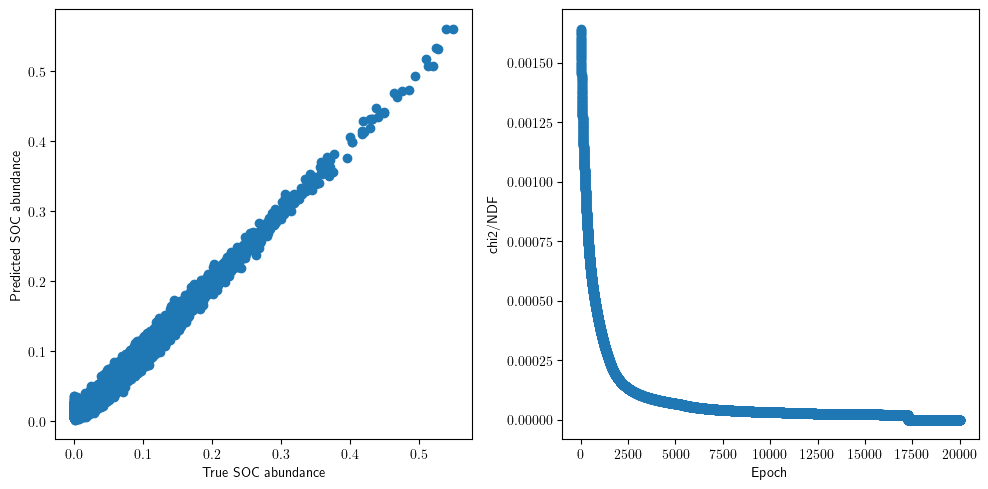

In [128]:
_, axarr = plt.subplots(1,2,figsize=(10,5))

axarr[0].scatter(msFullRaCAFit[:,-1],np.array(preds[:,-1].tolist()))
axarr[0].set_xlabel("True SOC abundance")
axarr[0].set_ylabel("Predicted SOC abundance")

axarr[1].scatter([i for i in range(lossTracking.shape[0])],lossTracking)
axarr[1].set_xlabel("Epoch")
axarr[1].set_ylabel("chi2/NDF")

plt.tight_layout()
plt.show()

#### Save seed encoder model

In [ ]:
import pickle

torch.save((seedEncoderModel,optimizer,preds,lossTracking), "step8_seedEncoder_E20k_lr0p000005_b1_0p99_b2_0p999.pt")

#### Compare against data

/tmp/ipykernel_12860/2082774099.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms = self.smax(y_mlp);


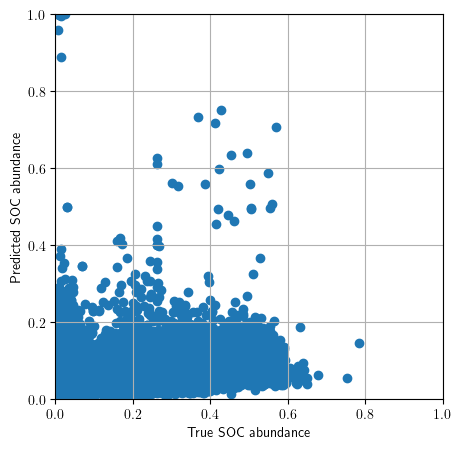

In [135]:
preds = seedEncoderModel(torch.tensor(dataI.tolist()).to(device))

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(sample_soc/100.,np.array(preds[:,-1].tolist()))
plt.xlabel("True SOC abundance");
plt.ylabel("Predicted SOC abundance");
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()

### Training full Encoder-Decoder Network

Set up GPU training.

In [136]:
print("Pytorch CUDA Version is ", torch.version.cuda)
print("Whether CUDA is supported by our system:", torch.cuda.is_available())
cuda_id = torch.cuda.current_device()
print("Name of the current CUDA Device: ", torch.cuda.get_device_name(cuda_id))
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Pytorch CUDA Version is  11.7
Whether CUDA is supported by our system: True
Name of the current CUDA Device:  NVIDIA GeForce RTX 4090
cuda


In [ ]:
rrFullRaCAFit = ttrrFull.detach().numpy()
msFullRaCAFit = ttmFull.detach().numpy()
FsFullRaCAFit = ttfFull.detach().numpy()
IhFullRaCAFit = ttIhat.detach().numpy()

In [194]:
# Model seeds: Fs, Ms, and rhorads
tFs      = torch.tensor(FsFullRaCAFit.tolist()).to(device)
tMs      = torch.tensor(msFullRaCAFit.tolist()).to(device)
trhorads = torch.tensor(rrFullRaCAFit.tolist()).to(device)

# Truth-level data:
tmsoc    = torch.tensor(sample_soc[dataIndices.astype('int')].tolist()).to(device)
tmsoc    = tmsoc / 100.
tIs      = torch.tensor(dataI[dataIndices.astype('int')].tolist()).to(device)

nepochs = 200000
encoderModel = seedEncoderModel.to(device)
decoderModel = LinearMixingDecoder(tFs, tMs, trhorads).to(device)
encoderDecoderParams = list(decoderModel.parameters()) + list(encoderModel.parameters())
optimizer = optim.Adam(encoderDecoderParams, lr = 0.000001, betas=(0.99,0.999))

In [195]:
encoderModelParams = filter(lambda p: p.requires_grad, encoderModel.parameters())
numEncoderParams = sum([np.prod(p.size()) for p in encoderModelParams])
print(numEncoderParams)

decoderModelParams = filter(lambda p: p.requires_grad, decoderModel.parameters())
numDecoderParams = sum([np.prod(p.size()) for p in decoderModelParams])
print(numDecoderParams)

1944360
193591.0


In [196]:
# Optimizer tracking
cEpoch = 0
lossTrackingEncoder = np.zeros(nepochs);
lossTrackingDecoder = np.zeros(nepochs);
lossTrackingDecoderLagrangeFactor = np.zeros(nepochs);

encoderPreds=[]
decoderPreds=[]

In [197]:
for epoch in tqdm(range(nepochs)) :
    # Get abundance predictions from encoder
    encoderPreds = encoderModel(tIs)
    
    # Get spectrum predictions from decoder
    decoderPreds = decoderModel(encoderPreds)
    
    # Compute encoder loss: sqerr from true Msoc values
    loss = 1000*torch.mean((encoderPreds[:,-1] - tmsoc)**2) 
    
    lossTrackingEncoder[cEpoch] = loss.detach().item()
    
    # Add decoder loss: sqerr from true RaCA spectra
    loss = loss + torch.mean((decoderPreds - tIs)**2) * decoderModel.computeLagrangeLossFactor()

    lossTrackingDecoder[cEpoch] = loss.detach().item() - lossTrackingEncoder[cEpoch]
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    cEpoch += 1

print("Epoch ",epoch,": ", lossTrackingEncoder[-1]+lossTrackingDecoder[-1])

  0%|          | 0/200000 [00:00<?, ?it/s]

/tmp/ipykernel_12860/2082774099.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms = self.smax(y_mlp);


Epoch  199999 :  0.006779483053833246


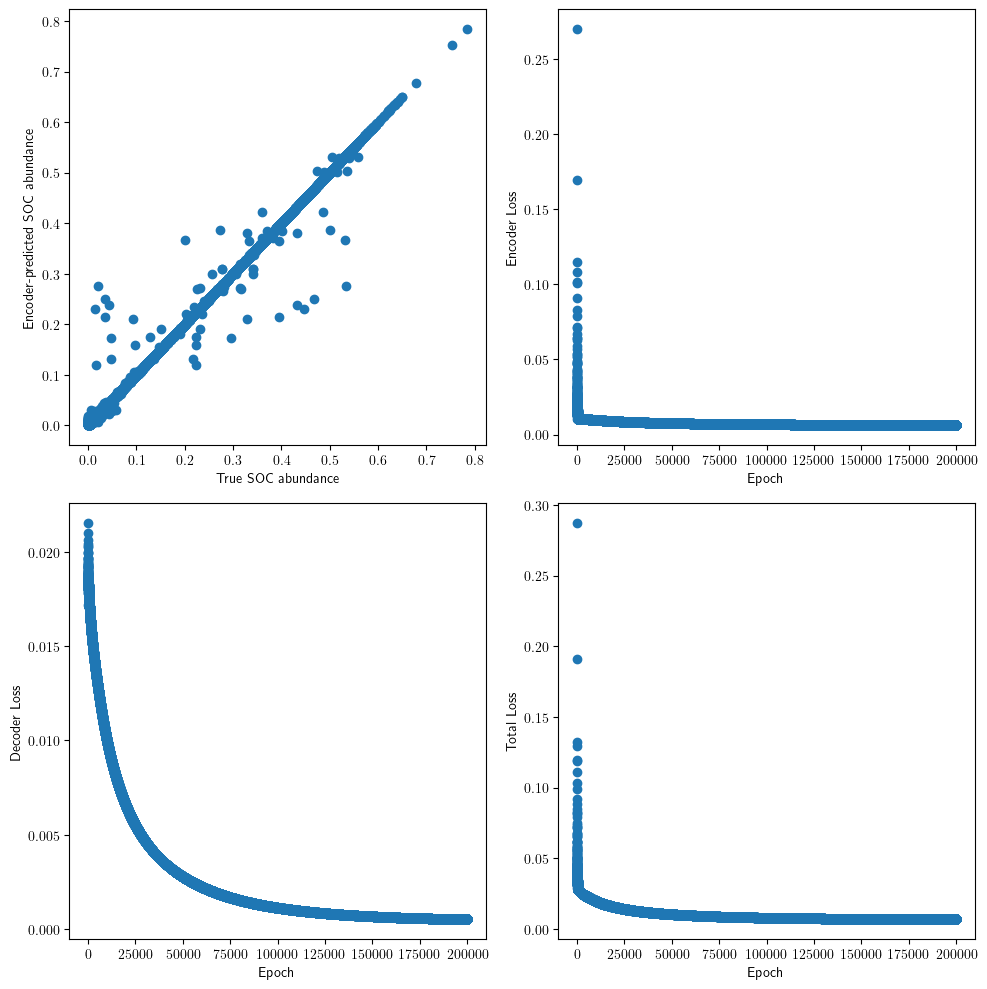

In [198]:
_, axarr = plt.subplots(2,2,figsize=(10,10))

axarr[0,0].scatter(np.array(tmsoc.tolist()),np.array(encoderPreds[:,-1].tolist()))
axarr[0,0].set_xlabel("True SOC abundance")
axarr[0,0].set_ylabel("Encoder-predicted SOC abundance")

axarr[0,1].scatter([i for i in range(cEpoch)],lossTrackingEncoder[:cEpoch])
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Encoder Loss")

axarr[1,0].scatter([i for i in range(cEpoch)],lossTrackingDecoder[:cEpoch])
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Decoder Loss")

axarr[1,1].scatter([i for i in range(cEpoch)],lossTrackingEncoder[:cEpoch]+lossTrackingDecoder[:cEpoch])
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("Total Loss")

plt.tight_layout()
plt.show()

In [199]:
import pickle

torch.save((encoderModel,decoderModel,optimizer,dataIndices,encoderPreds,decoderPreds,lossTrackingEncoder,lossTrackingDecoder), "step8_EncoderDecoder_E100k_lr0p00001_b1_0p99_b2_0p999.pt")

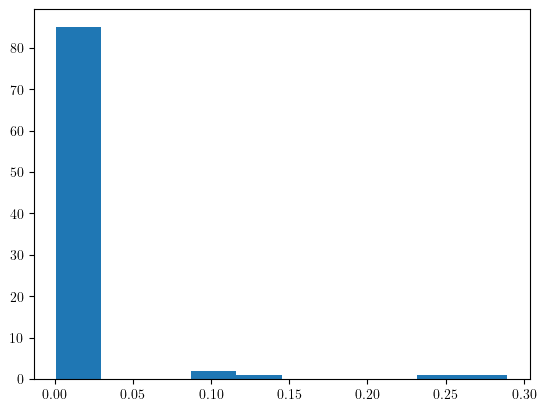

In [142]:
plt.hist(np.array(tMs[5,:].t().tolist()));
#plt.plot(XF,dataI[5,:])

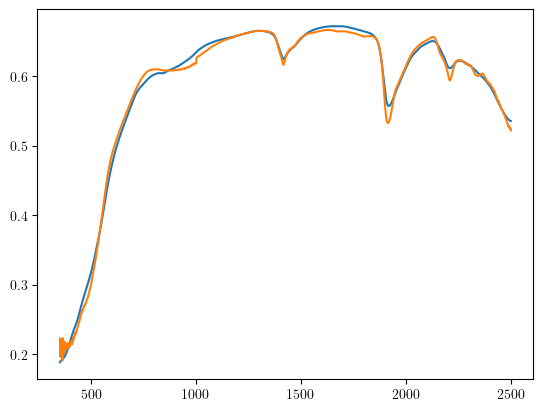

In [190]:
plt.plot(XF,np.array(torch.matmul(torchA(tMs[5:6,:],trhorads).float(),decoderModel.Fs.float()).tolist()).T)
plt.plot(XF,np.array(tIs[5:6,:].tolist()).T)

In [200]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()] + ["SOC"];
endMemList.remove("General")

  0%|          | 0/90 [00:00<?, ?it/s]

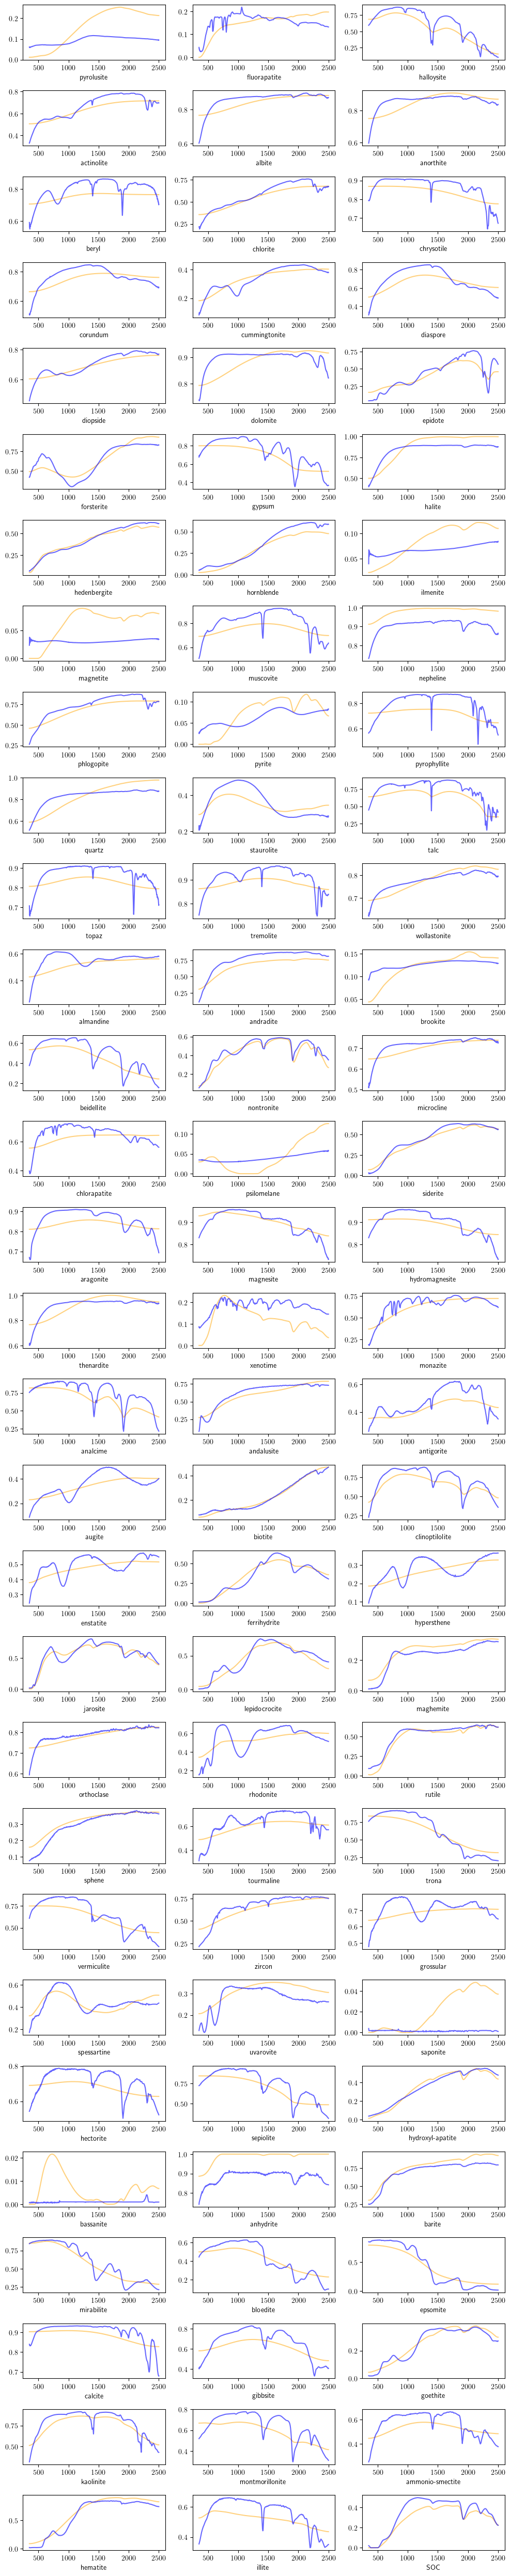

In [201]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in tqdm(range(KEndmembers)):

    col = index % 3
    
    # plot endmember distribution histogram
    axarr[curr_row,col].plot(XF,decoderModel.Fs.float().cpu().detach()[iEndmember,:],color='orange',alpha=0.5)
    axarr[curr_row,col].plot(XF, FsFullRaCAFit[iEndmember,:],color='blue',alpha=0.6)
    
    # style
    axarr[curr_row,col].set_xlabel(endMemList[iEndmember])
    #axarr[curr_row,col].set_xlabel("Wavelength [nm]")
    #axarr[curr_row,col].set_ylabel("Reflectance")
    #axarr[curr_row,col].grid()


    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()